<a href="https://colab.research.google.com/github/SSRaylia/Prediction-Using-Machine-Learning/blob/master/Zillow_House_Price_Prediction_ARIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore Zillow

## Ingest

In [0]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set(color_codes=True)
from sklearn.cluster import KMeans
color = sns.color_palette()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
from random import randrange
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/noahgift/real_estate_ml/master/data/Zip_Zhvi_SingleFamilyResidence_2018.csv")


## EDA

In [0]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
count,15508.000,15508.000,15508.000,14338.000,14338.000,14338.000,14338.000,14338.000,14338.000,14338.000,...,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000
mean,80789.618,47683.566,7754.500,115889.866,116007.379,116123.051,116235.493,116358.920,116501.681,116689.315,...,279359.582,280672.685,282148.749,283446.447,284466.282,285500.200,286717.307,288029.320,289187.510,290106.635
std,31521.485,29008.034,4476.918,85115.825,85264.209,85413.118,85566.676,85744.243,85958.867,86230.630,...,361868.364,361360.576,363102.089,365301.815,366277.876,367095.613,366772.521,364624.171,361143.146,359132.687
min,58196.000,1001.000,1.000,11300.000,11500.000,11600.000,11800.000,11800.000,12000.000,12100.000,...,21700.000,21700.000,22100.000,22200.000,22000.000,21800.000,21700.000,21500.000,21600.000,21900.000
25%,67215.000,22199.000,3877.750,66700.000,66800.000,66925.000,67100.000,67200.000,67300.000,67500.000,...,128300.000,128800.000,129675.000,130300.000,131100.000,131900.000,132900.000,134000.000,135100.000,135600.000
50%,77886.500,45792.500,7754.500,96500.000,96700.000,96750.000,96900.000,96900.000,97000.000,97150.000,...,191100.000,192150.000,193400.000,194600.000,195700.000,196900.000,198100.000,199600.000,201100.000,202150.000
75%,90314.250,74010.250,11631.250,140500.000,140600.000,140600.000,140800.000,141000.000,141100.000,141300.000,...,310750.000,312300.000,314325.000,316100.000,317425.000,318325.000,319800.000,321200.000,322425.000,323900.000
max,753844.000,99901.000,15508.000,3676700.000,3704200.000,3729600.000,3754600.000,3781800.000,3813500.000,3849600.000,...,17724700.000,17408900.000,17450500.000,17722800.000,18006700.000,18273800.000,18331900.000,18131900.000,17594900.000,17119600.000


#### Clean Up DataFrame
Rename RegionName to ZipCode and Change Zip Code to String 

In [0]:
df.rename(columns={"RegionName":"ZipCode"}, inplace=True)
df["ZipCode"]=df["ZipCode"].map(lambda x: "{:.0f}".format(x))
df["RegionID"]=df["RegionID"].map(lambda x: "{:.0f}".format(x))
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,334200.000,335400.000,336500.000,...,1037400,1038700,1041500,1042800,1042900,1044400,1047800,1049700,1048300,1047900
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.000,212200.000,212200.000,...,330400,332700,334500,335900,337000,338300,338400,336900,336000,336500
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,498100.000,500900.000,503100.000,...,1317900,1321100,1325300,1323800,1321200,1320700,1319500,1318800,1319700,1323300
3,93144,79936,El Paso,TX,El Paso,El Paso County,4,77300.000,77300.000,77300.000,...,120800,121300,122200,123000,123600,124500,125600,126300,126800,127400
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,95400.000,95600.000,95800.000,...,175500,176400,176900,176900,177300,178000,178500,179300,180200,180700


In [0]:
median_prices = df.median()

In [0]:
sf_df = df[df["City"] == "San Francisco"].median()
df_comparison = pd.concat([sf_df,median_prices], axis=1)
df_comparison.columns = ["San Francisco","Median USA"]
df_comparison.tail()


,San Francisco,Median USA
2018-08,1828600.000,196900.000
2018-09,1823200.000,198100.000
2018-10,1823700.000,199600.000
2018-11,1813400.000,201100.000
2018-12,1806000.000,202150.000


### Visualize

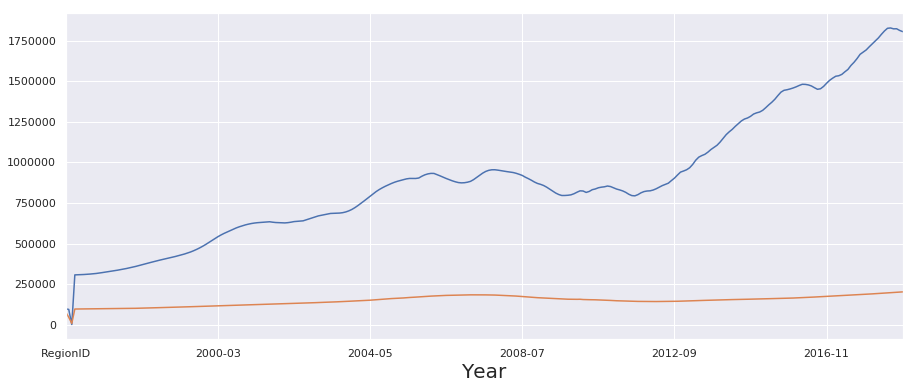

In [0]:
sf_df.plot(figsize=(15, 6))
median_prices.plot(figsize=(15, 6))
plt.xlabel('Year', fontsize=20);
plt.show()

## Modeling - ARIMA



In [0]:
city = df[(df["City"] == "San Francisco")]
city.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
9,97564,94109,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,10,766000.000,771100.000,776500.000,...,3761200,3810600,3876700,3942300,3982900,3993000,3999000,4014600,4009500,4016600
79,97565,94110,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,80,213900.000,214800.000,216000.000,...,1566500,1592600,1625200,1645500,1651200,1653600,1656100,1654100,1643000,1637100
348,97576,94122,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,349,278400.000,278300.000,278400.000,...,1396800,1405900,1417800,1430000,1441500,1449700,1457300,1463500,1460200,1456700
525,97567,94112,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,526,210100.000,210200.000,210300.000,...,1024500,1030500,1038500,1047300,1055300,1064600,1079100,1096700,1110100,1119700
776,97569,94115,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,777,794000.000,796500.000,799000.000,...,4135600,4149700,4169900,4194500,4222100,4238300,4236100,4241700,4231700,4221300


In [0]:
city = city.drop(['RegionID','ZipCode','City', 'State', 'Metro', 'CountyName', 'SizeRank'],axis=1)
city_transposed = city.transpose()


In [0]:
city_transposed['average'] = city_transposed.mean(numeric_only=True, axis=1)

In [0]:
city_transposed = city_transposed.dropna()

In [0]:
citymean = city_transposed['average']

In [0]:
X = citymean.values
X = X.reshape(-1, 1)
X_train = X[0:220]
X_test = X[220:]

In [0]:
model_arima = ARIMA(X_train,order=(1,1,1))
model_arima_fit=model_arima.fit()

In [0]:
predictions = model_arima_fit.forecast(steps=53)[0]
predictions

array([1652370.56672703, 1668574.80313005, 1684026.0395657 ,
       1698780.44691775, 1712890.00593938, 1726402.81982076,
       1739363.40344017, 1751812.95103826, 1763789.58392471,
       1775328.57970703, 1786462.58441971, 1797221.80882939,
       1807634.21009643, 1817725.65988521, 1827520.09993404,
       1837039.68602024, 1846304.92118582, 1855334.77902525,
       1864146.81777623, 1872757.2858999 , 1881181.21978505,
       1889432.53416406, 1897524.10578413, 1905467.85083694,
       1913274.79661237, 1920955.14780716, 1928518.34788715,
       1935973.13587218, 1943327.59888503, 1950589.22078041,
       1957764.92714641, 1964861.12694907, 1971883.75107036,
       1978838.28797141, 1985729.81669537, 1992563.03740843,
       1999342.29966259, 2006071.62855007, 2012754.74890682,
       2019395.10771041, 2025995.89480724, 2032560.06209352,
       2039090.34126539, 2045589.26024507, 2052059.15838154,
       2058502.20051741, 2064920.39000639, 2071315.58075978,
       2077689.48839425,

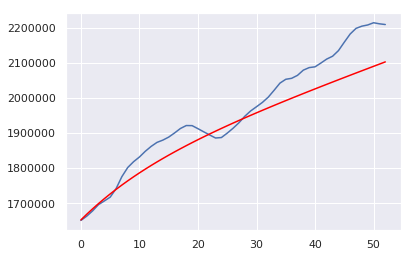

In [0]:
plt.plot(X_test)
plt.plot(predictions,color='red')

In [0]:
predictions = model_arima_fit.forecast(steps=100)[0]
predictions

array([1652370.56672703, 1668574.80313005, 1684026.0395657 ,
       1698780.44691775, 1712890.00593938, 1726402.81982076,
       1739363.40344017, 1751812.95103826, 1763789.58392471,
       1775328.57970703, 1786462.58441971, 1797221.80882939,
       1807634.21009643, 1817725.65988521, 1827520.09993404,
       1837039.68602024, 1846304.92118582, 1855334.77902525,
       1864146.81777623, 1872757.2858999 , 1881181.21978505,
       1889432.53416406, 1897524.10578413, 1905467.85083694,
       1913274.79661237, 1920955.14780716, 1928518.34788715,
       1935973.13587218, 1943327.59888503, 1950589.22078041,
       1957764.92714641, 1964861.12694907, 1971883.75107036,
       1978838.28797141, 1985729.81669537, 1992563.03740843,
       1999342.29966259, 2006071.62855007, 2012754.74890682,
       2019395.10771041, 2025995.89480724, 2032560.06209352,
       2039090.34126539, 2045589.26024507, 2052059.15838154,
       2058502.20051741, 2064920.39000639, 2071315.58075978,
       2077689.48839425,

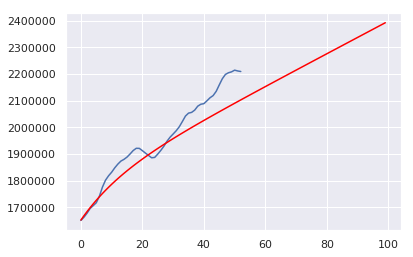

In [0]:
plt.plot(X_test)
plt.plot(predictions,color='red')